In [2]:
import pandas as pd
import numpy as np
from recommender_metrics.plots import LongTailPlot, CoveragePlot, MarkPlot
from recommender_metrics.metrics import mark, coverage, personalization, intra_list_similarity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [3]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [4]:
#only consider ratings from users who have rated over 1000 movies
users = ratings.userId.value_counts()
users = users[users>1000].index.tolist()

In [5]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [29]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,Action,Romance,Western,Comedy,Crime
movieId,,,,,
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,1,0


# Long Tail Plot Example

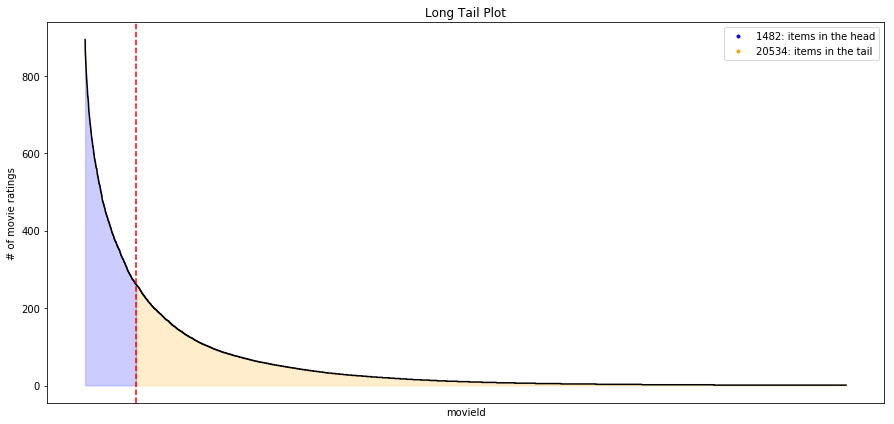

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
    
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Simple Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

## test/train split

In [8]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recommender_metrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
156,"[1025, 4610, 2049, 5131, 514, 2062, 3501, 5650..."
208,"[3088, 105504, 36, 2599, 1584, 52, 1077, 568, ..."
359,"[2560, 5635, 4103, 522, 67087, 539, 82461, 553..."
394,"[4612, 1029, 44555, 3090, 26131, 2076, 2090, 1..."
572,"[3081, 1036, 3087, 1047, 24, 39449, 27, 2084, ..."


In [9]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117


## Popularity Recommendations

In [10]:
#make popularity recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
156,"[1025, 4610, 2049, 5131, 514, 2062, 3501, 5650...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ..."
208,"[3088, 105504, 36, 2599, 1584, 52, 1077, 568, ...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ..."
359,"[2560, 5635, 4103, 522, 67087, 539, 82461, 553...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ..."
394,"[4612, 1029, 44555, 3090, 26131, 2076, 2090, 1...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ..."
572,"[3081, 1036, 3087, 1047, 24, 39449, 27, 2084, ...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ..."


In [11]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Collaborative Filter

In [12]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131160,131168,131176,131231,131239,131241,131243,131248,131250,131256
userId,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,0.0,3.0,3.0,4.0,4.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [14]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131160,131168,131176,131231,131239,131241,131243,131248,131250,131256
156,3.849096,3.858067,1.484838,2.292566,1.337767,3.312277,3.937976,0.608705,1.790538,4.176349,...,-0.001637,-0.001343,-0.034880,-0.027125,-0.001637,-0.001637,-0.001637,-0.001637,-0.001637,-0.001637
208,3.914828,0.213319,0.152150,0.640478,-0.206548,1.332362,0.363749,-0.063816,0.209328,0.230566,...,-0.010355,0.003159,0.005244,0.007403,-0.010355,-0.010355,-0.010355,-0.010355,-0.010355,-0.010355
359,4.448181,1.602935,0.270345,-0.408816,0.312489,4.240336,1.309779,0.037913,0.190047,2.180178,...,-0.007601,0.006624,-0.023059,-0.002051,-0.007601,-0.007601,-0.007601,-0.007601,-0.007601,-0.007601
394,4.013930,0.187124,0.235051,0.026676,0.168067,1.749029,-0.069004,0.023189,0.145258,1.525934,...,-0.018682,-0.012335,-0.032578,-0.084014,-0.018682,-0.018682,-0.018682,-0.018682,-0.018682,-0.018682
572,3.771648,2.040491,2.589601,-0.167024,1.817722,1.391835,0.636827,0.260301,0.156788,1.932903,...,-0.023247,0.007717,0.043356,0.016746,-0.023247,-0.023247,-0.023247,-0.023247,-0.023247,-0.023247


## Collaborative Filter Recommendations

In [15]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [16]:
get_users_predictions(156, 10, cf_model, train_long)

[3702, 593, 4855, 3708, 1721, 4014, 3361, 1259, 4018, 2467]

In [17]:
#make popularity recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,cf_predictions
userId,,,
156,"[1025, 4610, 2049, 5131, 514, 2062, 3501, 5650...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ...","[3702, 593, 4855, 3708, 1721, 4014, 3361, 1259..."
208,"[3088, 105504, 36, 2599, 1584, 52, 1077, 568, ...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ...","[1077, 912, 2599, 3007, 515, 3359, 3260, 6331,..."
359,"[2560, 5635, 4103, 522, 67087, 539, 82461, 553...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ...","[1200, 356, 30707, 1408, 47610, 6539, 1266, 37..."
394,"[4612, 1029, 44555, 3090, 26131, 2076, 2090, 1...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ...","[162, 111, 6331, 1, 903, 3730, 1265, 1189, 800..."
572,"[3081, 1036, 3087, 1047, 24, 39449, 27, 2084, ...","[1198, 1270, 593, 318, 2571, 2762, 1240, 608, ...","[44195, 1036, 2291, 3087, 51540, 55765, 34162,..."


In [18]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [19]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007717041800643086,
 0.0011682743837084673,
 0.0014612361557699177,
 0.0016488031439799932,
 0.0018202929617720613,
 0.0019882100750267953,
 0.002124483233807993,
 0.00224238248354004,
 0.00231502747579918,
 0.0024147059323908196]

In [20]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.007663451232583065,
 0.014571275455519827,
 0.0205091103965702,
 0.026229903536977496,
 0.03143247588424437,
 0.036264558770989636,
 0.04082894401061604,
 0.045205953656918284,
 0.04950629901835689,
 0.05340983599584886]

# Mark Plot

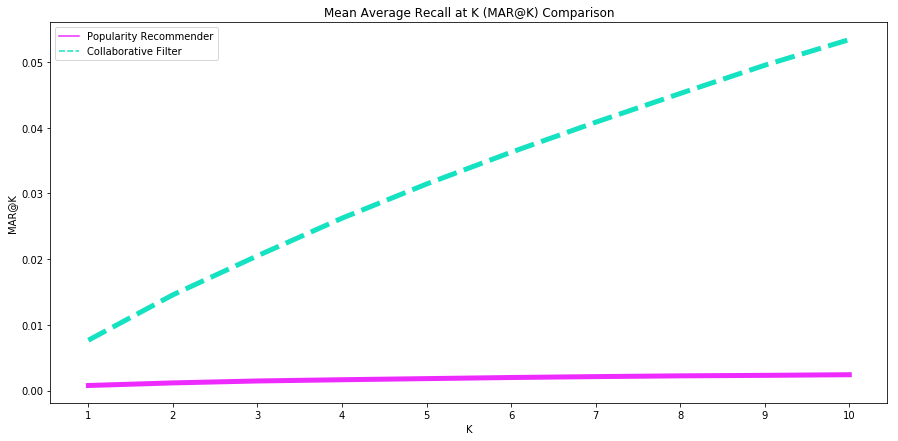

In [21]:
mark_scores = [pop_mark, cf_mark]
index = range(1,10+1)
names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [22]:
catalog = train_long.movieId.unique().tolist()
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)

# Coverage Plot

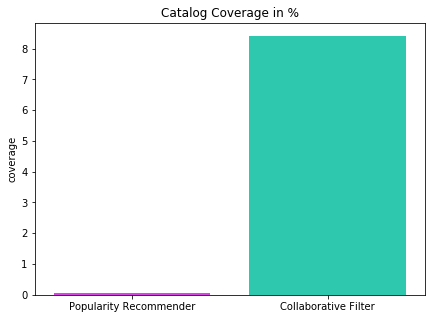

In [23]:
coverage_scores = [pop_coverage, cf_coverage]
model_names = ['Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

# Personalization

In [26]:
example_predictions = [
    ['A', 'B', 'C', 'D'],
    ['A', 'B', 'C', 'Y']
]

In [27]:
personalization(predicted=example_predictions)

0.25

# Intra-list Similarity

In [39]:
movies[movies.sum(axis=1)>0].head(5)

,Action,Romance,Western,Comedy,Crime
movieId,,,,,
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,1,0
6,1,0,0,0,0
7,0,0,0,1,0


In [41]:
intra_list_similarity(predicted=cf_predictions, feature_df=movies)

0.07709896391568417